# EDA on Use of Force Data and integration of crime and ACS data
This notebook is designed to show exploratory data analysis on use of force data and integration of ACS and crime additional datasets which have been collated throgh the code descirbed in the first steps of the repository. This is particularly helpful for anyone interested in the modelling, and aggregated information is the only one which can be shown for confidentiality reasons. The use of froce data is not yet publicly available and as such, the data file cannot be provided in the supporting materials. No rows of the dataframe will be shown. 
## Steps Overview:
1. Load cleaned use of force data
2. Derive time of day variable
3. Derive binary variable for DOJ report release on CPD unconsitutional conduct
4. Derive a cumulative force indicator (lag)
5. Explore civilian injury distribution for categorical variables
6. Explore civilian injury distribution of numeric variables
7. Integrate crime+acs data into the force dataset
8. Lag crime rates to reflect past month crime
9. Filter force data to exclude the period before February 2005 
10. Merge acs/crime data with force data on month, district and year
11. Add time-based features
12. Export dataset

In [24]:
import pandas as pd
import matplotlib
import seaborn as sns


In [25]:

print("pandas version:", pd.__version__)
print("matplotlib version:", matplotlib.__version__)
print("seaborn version:", sns.__version__)


pandas version: 2.0.3
matplotlib version: 3.7.2
seaborn version: 0.12.2


In [26]:
import matplotlib.pyplot as plt

In [27]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

## Step 1. Load cleaned use of force data

In [29]:
force= pd.read_parquet('force_clean_updated.parquet', engine='pyarrow')

In [30]:
print(force.columns)

Index(['uid_force', 'weapons_discharged', 'party_fired_first', 'gender',
       'race', 'appointed', 'rank', 'duty_status', 'in_uniform',
       'civilian_gender', 'civilian_race', 'civilian_armed',
       'civilian_injured', 'dt', 'uid', 'inside', 'civilian_age',
       'subject_resistance', 'member_action_severity', 'district',
       'experience_years', 'experience_months'],
      dtype='object')


In [35]:
print(force.dtypes)

uid_force                         object
weapons_discharged               float64
party_fired_first                 object
gender                            object
race                              object
appointed                 datetime64[ns]
rank                              object
duty_status                         bool
in_uniform                          bool
civilian_gender                   object
civilian_race                     object
civilian_armed                      bool
civilian_injured                    bool
dt                        datetime64[ns]
uid                               object
inside                              bool
civilian_age                     float64
subject_resistance                object
member_action_severity            object
district                          object
experience_years                 float64
experience_months                float64
dtype: object


In [39]:
#Drop appointed and uid_force as they're no longer needed
columns_to_drop = ['uid_force', 'appointed']

force = force.drop(columns=columns_to_drop)

In [41]:
#Round experience_years to whole numbers
force['experience_years'] = force['experience_years'].round()

## Step 2: Derive time of day variable
Daytime/Nighttime

In [44]:
# Extract hour and group it 
def categorize_time_of_day(hour):
    if 6 <= hour < 18:
        return 'Daytime'
    else:
        return 'Nighttime'

# Apply categorization and create time_of_day
force['hour'] = force['dt'].dt.hour
force['time_of_day'] = force['hour'].apply(categorize_time_of_day)

## Step 3: Derive binary variable for DOJ report release on CPD unconsitutional conduct

In [47]:
# Define DOJ report on CPD release variable
doj_decision_date = pd.to_datetime('2017-01-13')  

# Create a binary dummy column: 1 if the event happened after the DOJ decision date, else 0
force['doj_decision'] = (force['dt'] >= doj_decision_date).astype(int)

# Check the new dummy variable
print(force[['dt', 'doj_decision']].head())

                   dt  doj_decision
0 2004-01-08 03:00:00             0
1 2004-01-17 14:47:00             0
2 2004-01-17 14:47:00             0
3 2004-01-17 20:04:00             0
4 2004-01-18 04:26:00             0


## Step 4: Derive a cumulative force indicator (lag) 
Previous use of force might be an important factor in predicting civilian injury, epsecially if some officers are particularly prone to engage in use of force actions on regular basis

In [59]:
#Cumulative force
# the data by officer ID ('uid') and the datetime of the incident ('dt')
force = force.sort_values(by=['uid', 'dt'])

# Create a 'use_of_force' column to indicate whether a force incident occurred (set as 1 for every row)
force['use_of_force'] = 1  
# Create a 'cumulative_use_of_force' lag for each officer
force['cumulative_force'] = force.groupby('uid')['use_of_force'].cumsum() - 1


In [61]:
# Re-sort the DataFrame based on the 'dt' column to restore chronological order
force = force.sort_values(by='dt').reset_index(drop=True)

In [63]:
#Verify that the cumulative_force column is calculated correctly 
#officer_sample = force[force['uid'] == '-']  #Cannot disclose office uids due to data privacy considerations
#print(officer_sample[['dt', 'cumulative_force']].head(10))

## Step 5: Explore civilian injury distribution by categorical variables


In [66]:
print(force.columns)

Index(['weapons_discharged', 'party_fired_first', 'gender', 'race', 'rank',
       'duty_status', 'in_uniform', 'civilian_gender', 'civilian_race',
       'civilian_armed', 'civilian_injured', 'dt', 'uid', 'inside',
       'civilian_age', 'subject_resistance', 'member_action_severity',
       'district', 'experience_years', 'experience_months', 'hour',
       'time_of_day', 'doj_decision', 'use_of_force', 'cumulative_force'],
      dtype='object')


In [68]:
# Explore the distribution of each categorical feature by civilian_injured
categorical_features = ['weapons_discharged', 'party_fired_first', 'gender', 'race', 'civilian_gender', 'rank', 'civilian_armed', 'duty_status', 
                        'civilian_race', 'district', 'in_uniform', 'inside', 'time_of_day', 'subject_resistance', 'member_action_severity', 'doj_decision']

In [70]:
# Check the proportion of 'Unknown' in member_action_severity and remove it
unknown_proportion = force[force['member_action_severity'] == 'Unknown'].shape[0] / force.shape[0]
print(f"Proportion of 'Unknown' in member_action_severity: {unknown_proportion:.2%}")
#Drop rows with 'Unknown'
force = force[force['member_action_severity'] != 'Unknown']

Proportion of 'Unknown' in member_action_severity: 1.69%


In [72]:
# Check the shape of the cleaned dataset to ensure rows were dropped
print("Final dataset shape:", force.shape)

Final dataset shape: (75389, 25)


In [74]:
# Create tables showing percentages for each category where civilian_injured is True
for feature in categorical_features:
    print(f"\nDistribution of '{feature}' by 'civilian_injured' (Percentage of True):")
    crosstab = pd.crosstab(force[feature], force['civilian_injured'], normalize='index') * 100
    
    # Filter only the 'True' column ('civilian_injured' is a boolean)
    if True in crosstab.columns:
        crosstab_true = crosstab[True].sort_values(ascending=False)
        print(crosstab_true)
    else:
        print(f"No 'True' values found for {feature}")


Distribution of 'weapons_discharged' by 'civilian_injured' (Percentage of True):
weapons_discharged
3.0    57.142857
4.0    50.000000
2.0    45.258621
1.0    42.062532
0.0    22.564598
Name: True, dtype: float64

Distribution of 'party_fired_first' by 'civilian_injured' (Percentage of True):
party_fired_first
OFFENDER      65.000000
MEMBER        41.307872
OTHER         35.922330
NONE FIRED    22.564598
Name: True, dtype: float64

Distribution of 'gender' by 'civilian_injured' (Percentage of True):
gender
M    24.841494
F    18.380290
Name: True, dtype: float64

Distribution of 'race' by 'civilian_injured' (Percentage of True):
race
Native American    25.827815
Asian              24.675886
Hispanic           24.610332
White              24.036286
Black              23.650235
Name: True, dtype: float64

Distribution of 'civilian_gender' by 'civilian_injured' (Percentage of True):
civilian_gender
MALE      26.183349
FEMALE    12.481109
Name: True, dtype: float64

Distribution of 'rank' 

## Party Fired First

In [77]:
# Party Fired First (4 categories)
party_fired_categories = {
    'OFFENDER': 'Civilian',
    'MEMBER': 'Officer',
    'NONE FIRED': 'None Fired',
    'OTHER': 'Other'
}
force['party_fired_first'] = force['party_fired_first'].replace(party_fired_categories)


<Figure size 1000x600 with 0 Axes>

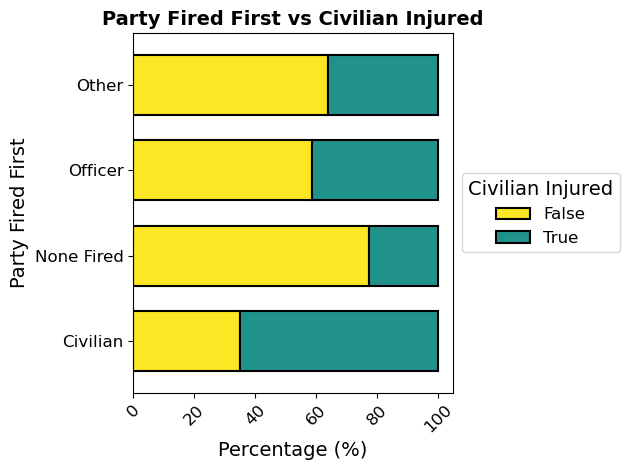

In [79]:
# Create a crosstab to calculate the count of each category
crosstab = pd.crosstab(force['party_fired_first'], force['civilian_injured'], normalize='index') * 100

# Plot the stacked bar chart with percentages
plt.figure(figsize=(10, 6))
ax = crosstab.plot(kind='barh', stacked=True, color=['#fde725', '#21918c'], edgecolor='black', linewidth=1.5, width=0.7)

# Customize the title, labels, and legend
plt.title('Party Fired First vs Civilian Injured', fontsize=14, fontweight='bold')
plt.xlabel('Percentage (%)', fontsize=14)
plt.ylabel('Party Fired First', fontsize=14)

# Move the legend outside the plot
plt.legend(title='Civilian Injured', title_fontsize='14', fontsize='12', loc='center left', bbox_to_anchor=(1, 0.5))

# Increase the size of the x-axis and y-axis labels for readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adjust the layout to fit the legend
plt.tight_layout()

plt.show()

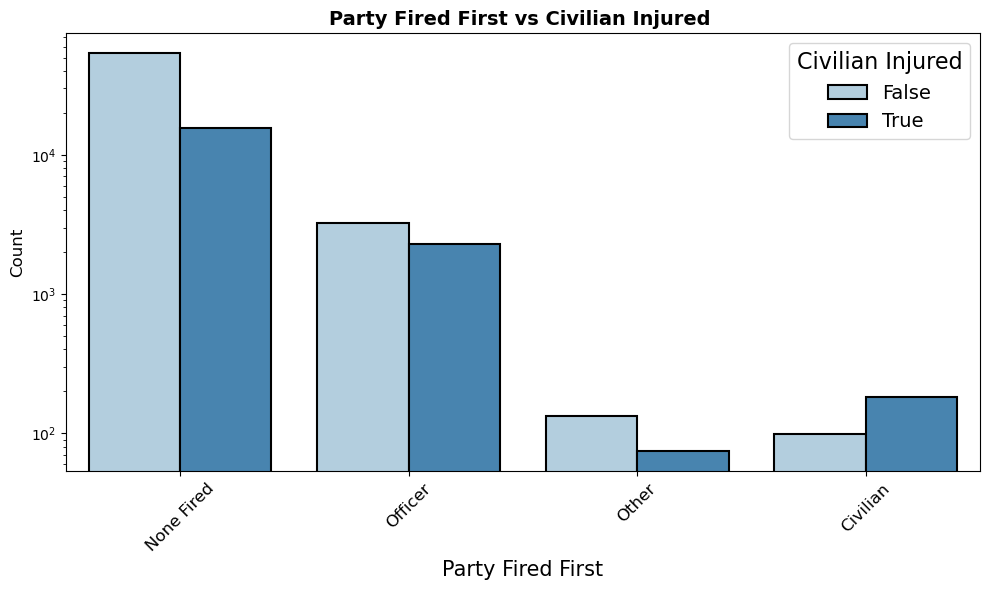

In [81]:
aesthetic_palette = sns.color_palette("Blues", n_colors=2)  # You can try "Blues", "Set1", "muted" etc.

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='party_fired_first', hue='civilian_injured', data=force, palette=aesthetic_palette)

for patch in ax.patches:
    patch.set_edgecolor('black')  # Set the outline color to black
    patch.set_linewidth(1.5)  # Set the thickness of the outline

plt.title('Party Fired First vs Civilian Injured ', fontsize=14, fontweight='bold')
plt.xlabel('Party Fired First', fontsize=15)
plt.ylabel('Count', fontsize=12)
plt.yscale('log')  # Apply log scale to the y-axis
plt.legend(title='Civilian Injured', title_fontsize='16', fontsize='14')
# Increase the size of the x-axis category labels (zoom the labels)
plt.xticks(rotation=45, fontsize=12)  # Adjust the fontsize for better readability

# Adjust the layout to avoid overlap
plt.tight_layout()

plt.show()

## Gender (Officer)

In [84]:
# Gender (M/F to Male/Female)
gender_map = {'M': 'Male', 'F': 'Female'}
force['gender'] = force['gender'].replace(gender_map)

In [86]:
# Gender (MALE/FEMALE to Male/Female)
gender_map2 = {'MALE': 'Male', 'FEMALE': 'Female'}
force['civilian_gender'] = force['civilian_gender'].replace(gender_map2)

In [88]:
# Use specific viridis colors for plotting
viridis_colors = ['#fde725', '#21918c']

<Figure size 1000x600 with 0 Axes>

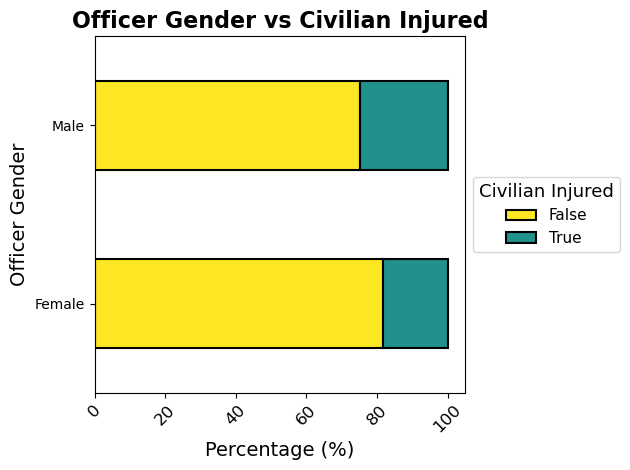

In [90]:
# Gender vs Civilian Injured (Stacked)
crosstab_gender = pd.crosstab(force['gender'], force['civilian_injured'], normalize='index') * 100

plt.figure(figsize=(10, 6))
crosstab_gender.plot(kind='barh', stacked=True, color=['#fde725', '#21918c'], edgecolor='black', linewidth=1.5)
plt.title('Officer Gender vs Civilian Injured', fontsize=16, fontweight='bold')
plt.xlabel('Percentage (%)', fontsize=14)
plt.ylabel('Officer Gender', fontsize=14)
plt.legend(title='Civilian Injured', title_fontsize='13', fontsize='11', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

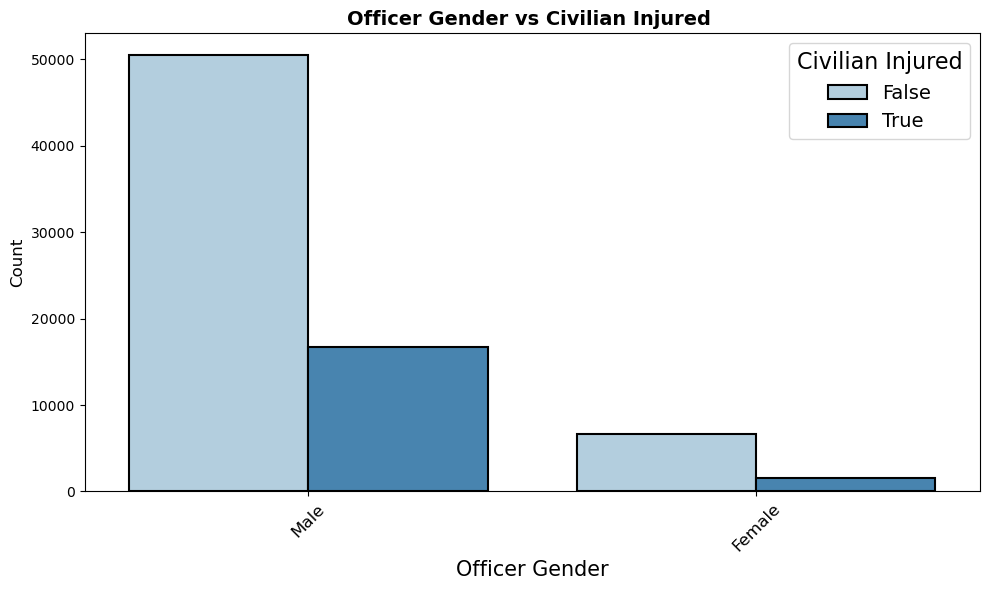

In [92]:
aesthetic_palette = sns.color_palette("Blues", n_colors=2)  # You can try "Blues", "Set1", "muted" etc.

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='gender', hue='civilian_injured', data=force, palette=aesthetic_palette)

for patch in ax.patches:
    patch.set_edgecolor('black')  # Set the outline color to black
    patch.set_linewidth(1.5)  # Set the thickness of the outline

plt.title('Officer Gender vs Civilian Injured ', fontsize=14, fontweight='bold')
plt.xlabel('Officer Gender', fontsize=15)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Civilian Injured', title_fontsize='16', fontsize='14')
# Increase the size of the x-axis category labels (zoom the labels)
plt.xticks(rotation=45, fontsize=12)  # Adjust the fontsize for better readability

# Adjust the layout to avoid overlap
plt.tight_layout()

plt.show()

## Officer in uniform

<Figure size 1000x600 with 0 Axes>

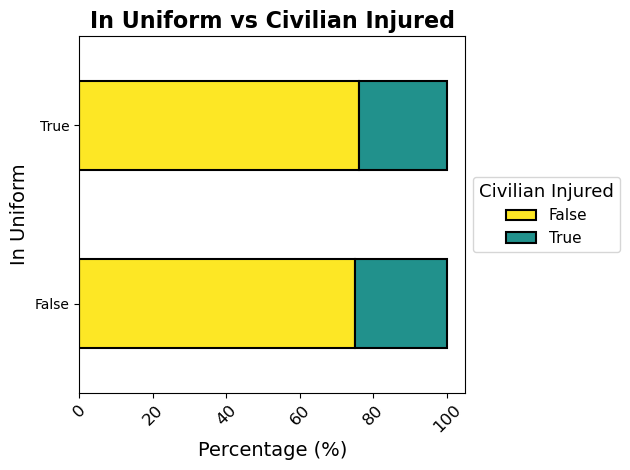

In [95]:
# In Uniform vs Civilian Injured (Stacked)
crosstab_in_uniform = pd.crosstab(force['in_uniform'], force['civilian_injured'], normalize='index') * 100

plt.figure(figsize=(10, 6))
crosstab_in_uniform.plot(kind='barh', stacked=True, color=['#fde725', '#21918c'], edgecolor='black', linewidth=1.5)
plt.title('In Uniform vs Civilian Injured', fontsize=16, fontweight='bold')
plt.xlabel('Percentage (%)', fontsize=14)
plt.ylabel('In Uniform', fontsize=14)
plt.legend(title='Civilian Injured', title_fontsize='13', fontsize='11', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

## Officer Race

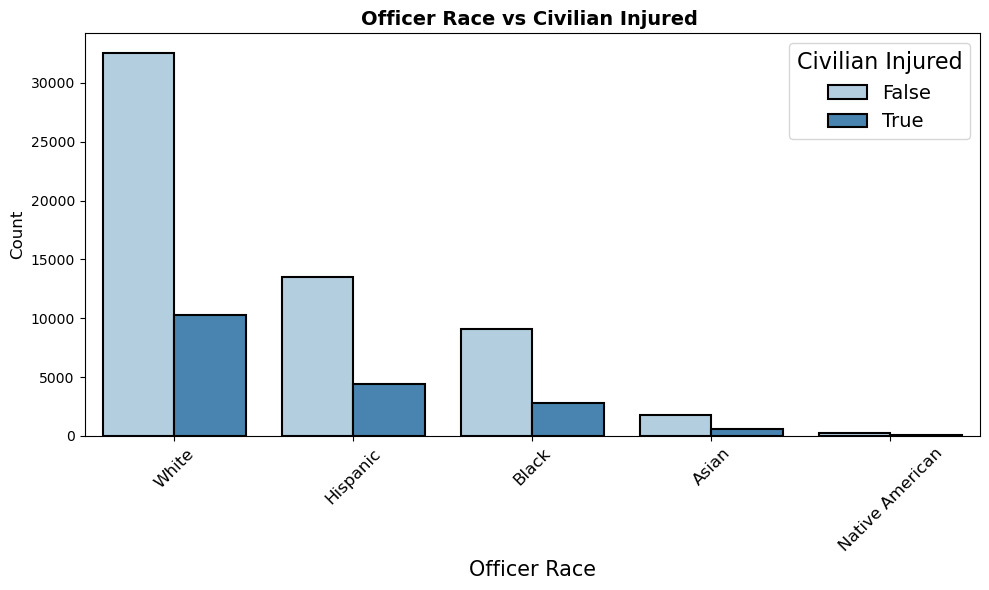

In [98]:
aesthetic_palette = sns.color_palette("Blues", n_colors=2)  # You can try "Blues", "Set1", "muted" etc.

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='race', hue='civilian_injured', data=force, palette=aesthetic_palette)

for patch in ax.patches:
    patch.set_edgecolor('black')  # Set the outline color to black
    patch.set_linewidth(1.5)  # Set the thickness of the outline

plt.title('Officer Race vs Civilian Injured ', fontsize=14, fontweight='bold')
plt.xlabel('Officer Race', fontsize=15)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Civilian Injured', title_fontsize='16', fontsize='14')
# Increase the size of the x-axis category labels (zoom the labels)
plt.xticks(rotation=45, fontsize=12)  # Adjust the fontsize for better readability

# Adjust the layout to avoid overlap
plt.tight_layout()

plt.show()

<Figure size 1000x600 with 0 Axes>

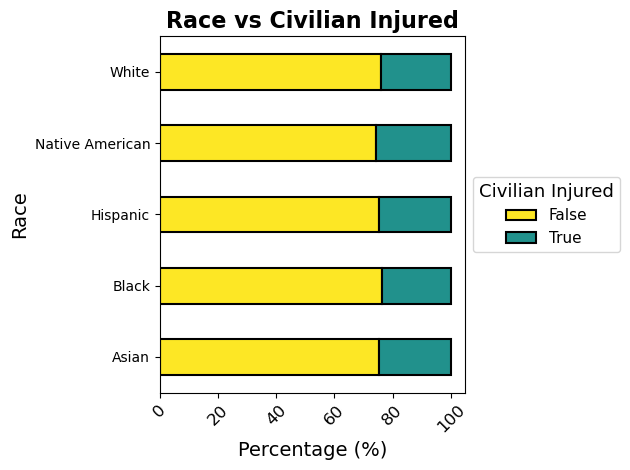

In [100]:
# Stacked bar plot for Race vs Civilian Injured
crosstab_race = pd.crosstab(force['race'], force['civilian_injured'], normalize='index') * 100

plt.figure(figsize=(10, 6))
crosstab_race.plot(kind='barh', stacked=True, color=['#fde725', '#21918c'], edgecolor='black', linewidth=1.5)
plt.title('Race vs Civilian Injured', fontsize=16, fontweight='bold')
plt.xlabel('Percentage (%)', fontsize=14)
plt.ylabel('Race', fontsize=14)
plt.legend(title='Civilian Injured', title_fontsize='13', fontsize='11', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()


## Officer Rank


<Figure size 1200x600 with 0 Axes>

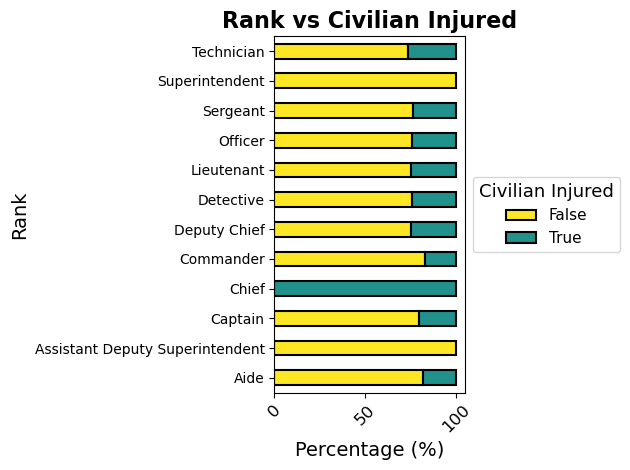

In [103]:
# Stacked bar plot for Rank vs Civilian Injured
crosstab_rank = pd.crosstab(force['rank'], force['civilian_injured'], normalize='index') * 100

plt.figure(figsize=(12, 6))
crosstab_rank.plot(kind='barh', stacked=True, color=['#fde725', '#21918c'], edgecolor='black', linewidth=1.5)
plt.title('Rank vs Civilian Injured', fontsize=16, fontweight='bold')
plt.xlabel('Percentage (%)', fontsize=14)
plt.ylabel('Rank', fontsize=14)
plt.legend(title='Civilian Injured', title_fontsize='13', fontsize='11', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

## Civilian Race

<Figure size 1000x600 with 0 Axes>

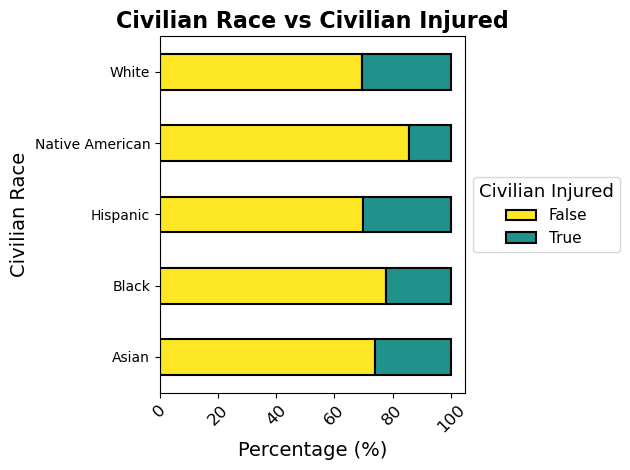

In [106]:
# Stacked bar plot for Civilian Race vs Civilian Injured
crosstab_civ_race = pd.crosstab(force['civilian_race'], force['civilian_injured'], normalize='index') * 100

plt.figure(figsize=(10, 6))
crosstab_civ_race.plot(kind='barh', stacked=True, color=['#fde725', '#21918c'], edgecolor='black', linewidth=1.5)
plt.title('Civilian Race vs Civilian Injured', fontsize=16, fontweight='bold')
plt.xlabel('Percentage (%)', fontsize=14)
plt.ylabel('Civilian Race', fontsize=14)
plt.legend(title='Civilian Injured', title_fontsize='13', fontsize='11', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

## Subject Resistance

<Figure size 1000x600 with 0 Axes>

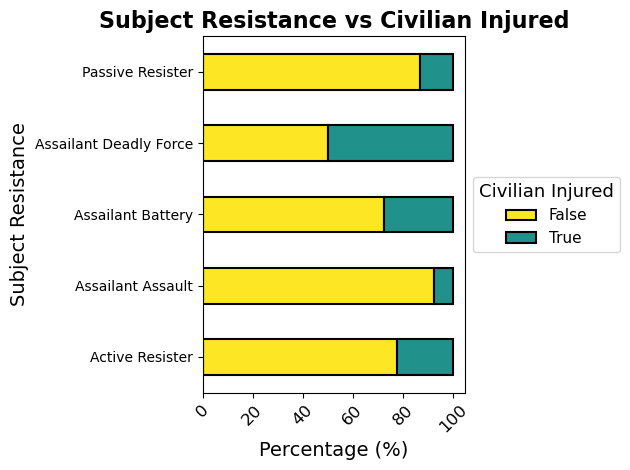

In [109]:
# Stacked bar plot for Subject Resistance vs Civilian Injured
crosstab_resistance = pd.crosstab(force['subject_resistance'], force['civilian_injured'], normalize='index') * 100

plt.figure(figsize=(10, 6))
crosstab_resistance.plot(kind='barh', stacked=True, color=['#fde725', '#21918c'], edgecolor='black', linewidth=1.5)
plt.title('Subject Resistance vs Civilian Injured', fontsize=16, fontweight='bold')
plt.xlabel('Percentage (%)', fontsize=14)
plt.ylabel('Subject Resistance', fontsize=14)
plt.legend(title='Civilian Injured', title_fontsize='13', fontsize='11', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

## Member Action Severity

<Figure size 1800x1500 with 0 Axes>

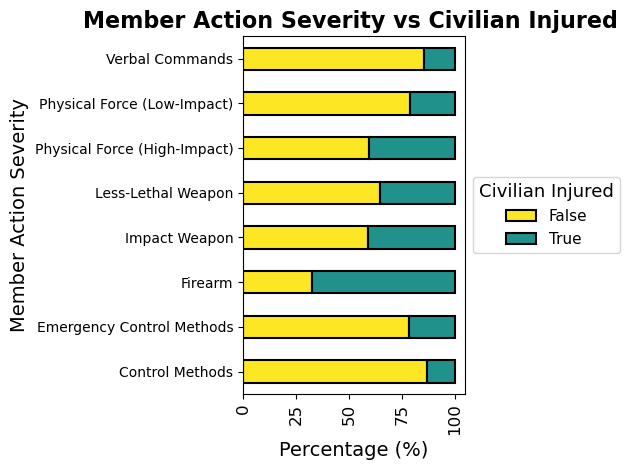

In [112]:
# Stacked bar plot for Member Action Severity vs Civilian Injured
crosstab_action = pd.crosstab(force['member_action_severity'], force['civilian_injured'], normalize='index') * 100

plt.figure(figsize=(18, 15))
crosstab_action.plot(kind='barh', stacked=True, color=['#fde725', '#21918c'], edgecolor='black', linewidth=1.5)
plt.title('Member Action Severity vs Civilian Injured ', fontsize=16, fontweight='bold')
plt.xlabel('Percentage (%)', fontsize=14)
plt.ylabel('Member Action Severity', fontsize=14)
plt.legend(title='Civilian Injured', title_fontsize='13', fontsize='11', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()
plt.show()

## Police District

<Figure size 3000x3000 with 0 Axes>

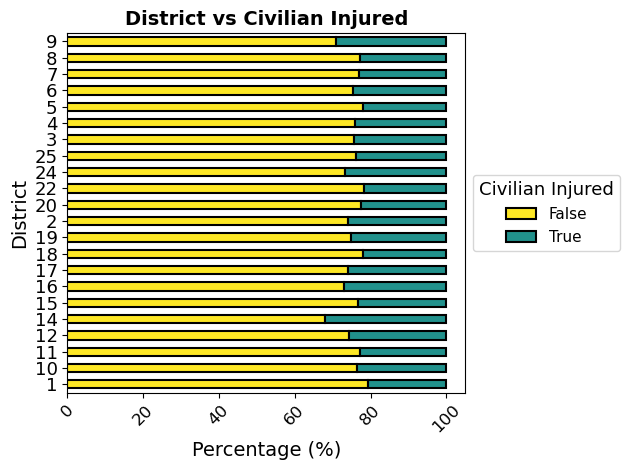

In [115]:
# Stacked bar plot for District vs Civilian Injured
crosstab_district = pd.crosstab(force['district'], force['civilian_injured'], normalize='index') * 100

plt.figure(figsize=(30, 30))
crosstab_district.plot(kind='barh', stacked=True, color=['#fde725', '#21918c'], edgecolor='black', linewidth=1.5)
plt.title('District vs Civilian Injured', fontsize=14, fontweight='bold')
plt.xlabel('Percentage (%)', fontsize=14)
plt.ylabel('District', fontsize=14)
plt.legend(title='Civilian Injured', title_fontsize='13', fontsize='11', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=13)
plt.tight_layout()
plt.show()

## Tables for binary variables

In [117]:
# Create a summary table for binary variables
binary_vars = ['civilian_injured', 'gender', 'civilian_gender', 'civilian_armed','in_uniform', 'duty_status', 'inside', 'time_of_day']
for var in binary_vars:
    crosstab = pd.crosstab(force[var], force['civilian_injured'], normalize='index') * 100
    print(f"\n{var.capitalize()} vs Civilian Injured (%):")
    print(crosstab)


Civilian_injured vs Civilian Injured (%):
civilian_injured  False  True 
civilian_injured              
False             100.0    0.0
True                0.0  100.0

Gender vs Civilian Injured (%):
civilian_injured      False      True 
gender                                
Female            81.619710  18.380290
Male              75.158506  24.841494

Civilian_gender vs Civilian Injured (%):
civilian_injured      False      True 
civilian_gender                       
Female            87.518891  12.481109
Male              73.816651  26.183349

Civilian_armed vs Civilian Injured (%):
civilian_injured      False      True 
civilian_armed                        
False             77.165552  22.834448
True              64.534361  35.465639

In_uniform vs Civilian Injured (%):
civilian_injured      False      True 
in_uniform                            
False             75.128842  24.871158
True              76.157817  23.842183

Duty_status vs Civilian Injured (%):
civilian_injured  

## Alternative encodings for rank and weapons discharged

In [121]:
# Binary encoding for weapons_discharged
force['weapons_discharged_binary'] = force['weapons_discharged'].apply(lambda x: 1 if x > 0 else 0)

In [123]:
# Define rank mapping: group ranks into Low, Mid, and Senior levels
rank_mapping = {
    'Officer': 'Low Rank', 
    'Technician': 'Low Rank', 
    'Aide': 'Low Rank',
    'Detective': 'Low Rank',
    'Agent': 'Low Rank',
    'Sergeant': 'Mid Rank',
    'Lieutenant': 'Mid Rank', 
    'Captain': 'Mid Rank',
    'Commander': 'Senior Rank', 
    'Deputy Chief': 'Senior Rank', 
    'Chief': 'Senior Rank',
    'Superintendent': 'Senior Rank',
    'Assistant Deputy Superintendent': 'Senior Rank'
}

# Apply the mapping to the rank column
force['rank_grouped'] = force['rank'].replace(rank_mapping)

## Step 5: Explore civilian injury distribution of numeric variables

## KDE Plots for for civilian age, experience years, and cumulative force by injury status

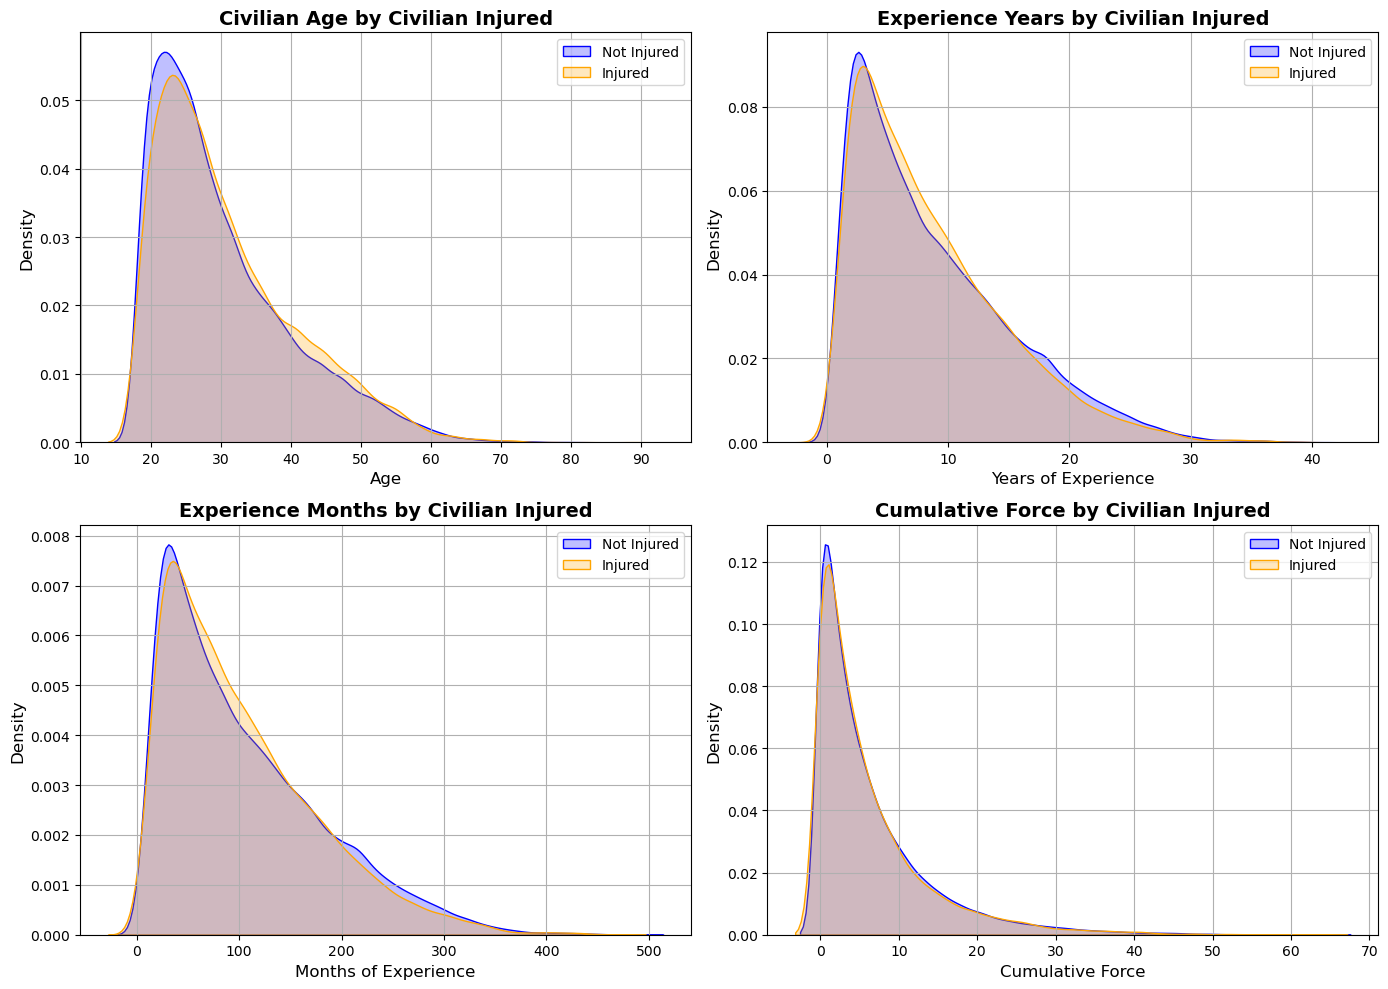

In [127]:
# Create KDE plots for civilian age, experience years, and cumulative force by injury status
plt.figure(figsize=(14, 10))

# Civilian Age
plt.subplot(2, 2, 1)
sns.kdeplot(force[force['civilian_injured'] == False]['civilian_age'], label='Not Injured', shade=True, color='blue')
sns.kdeplot(force[force['civilian_injured'] == True]['civilian_age'], label='Injured', shade=True, color='orange')
plt.title('Civilian Age by Civilian Injured', fontsize=14, fontweight='bold')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.legend()

# Experience Years
plt.subplot(2, 2, 2)
sns.kdeplot(force[force['civilian_injured'] == False]['experience_years'], label='Not Injured', shade=True, color='blue')
sns.kdeplot(force[force['civilian_injured'] == True]['experience_years'], label='Injured', shade=True, color='orange')
plt.title('Experience Years by Civilian Injured', fontsize=14, fontweight='bold')
plt.xlabel('Years of Experience', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.legend()

# Experience Months
plt.subplot(2, 2, 3)
sns.kdeplot(force[force['civilian_injured'] == False]['experience_months'], label='Not Injured', shade=True, color='blue')
sns.kdeplot(force[force['civilian_injured'] == True]['experience_months'], label='Injured', shade=True, color='orange')
plt.title('Experience Months by Civilian Injured', fontsize=14, fontweight='bold')
plt.xlabel('Months of Experience', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.legend()

# Cumulative Force
plt.subplot(2, 2, 4)
sns.kdeplot(force[force['civilian_injured'] == False]['cumulative_force'], label='Not Injured', shade=True, color='blue')
sns.kdeplot(force[force['civilian_injured'] == True]['cumulative_force'], label='Injured', shade=True, color='orange')
plt.title('Cumulative Force by Civilian Injured', fontsize=14, fontweight='bold')
plt.xlabel('Cumulative Force', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

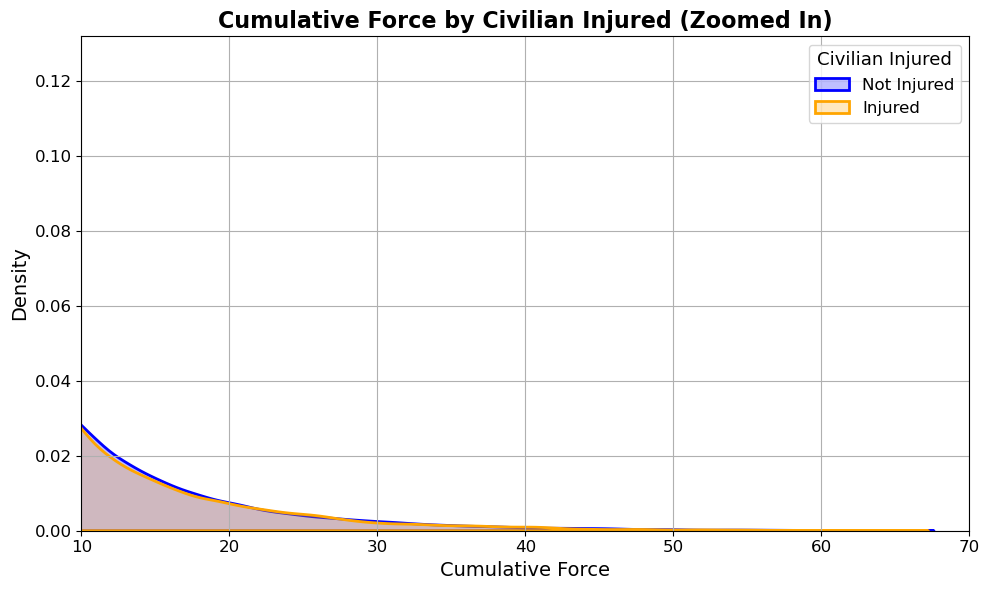

In [128]:
# Standalone KDE plot for Cumulative Force by Civilian Injured with a zoomed-in tail
plt.figure(figsize=(10, 6))

# Plot for Cumulative Force
sns.kdeplot(force[force['civilian_injured'] == False]['cumulative_force'], 
            label='Not Injured', shade=True, color='blue', linewidth=2)
sns.kdeplot(force[force['civilian_injured'] == True]['cumulative_force'], 
            label='Injured', shade=True, color='orange', linewidth=2)

# Customize the plot
plt.title('Cumulative Force by Civilian Injured (Zoomed In)', fontsize=16, fontweight='bold')
plt.xlabel('Cumulative Force', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Civilian Injured', fontsize=12, title_fontsize=13)
plt.grid(True)

# Zoom in on the tail by setting x-axis limits (e.g., focus on values from 10 onwards)
plt.xlim(10, 70)

# Adjust the layout to fit well
plt.tight_layout()

plt.show()

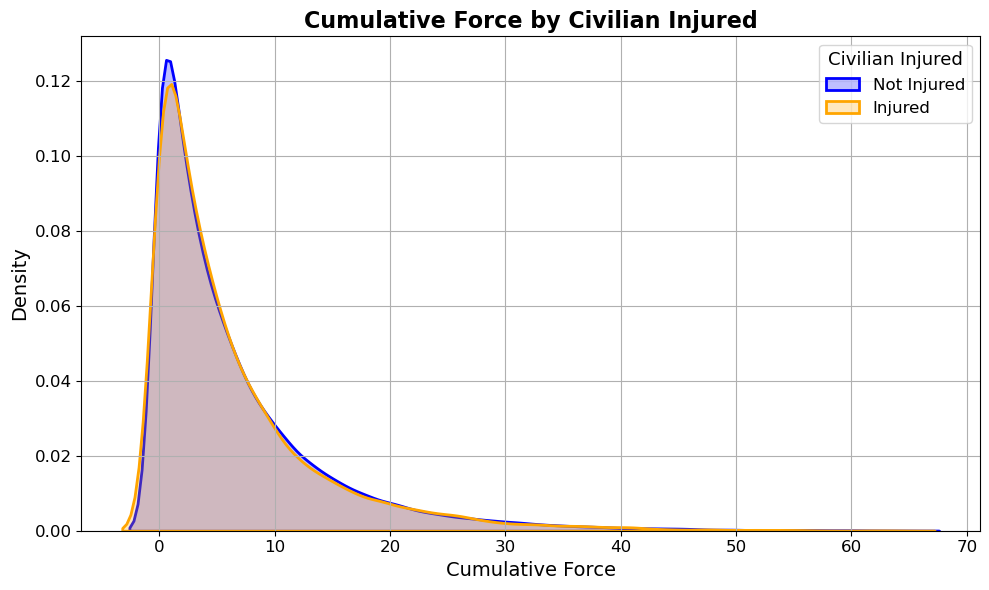

In [131]:
# Standalone KDE plot for Cumulative Officer Force by Civilian Injured
plt.figure(figsize=(10, 6))

# Plot for Cumulative Force
sns.kdeplot(force[force['civilian_injured'] == False]['cumulative_force'], 
            label='Not Injured', shade=True, color='blue', linewidth=2)
sns.kdeplot(force[force['civilian_injured'] == True]['cumulative_force'], 
            label='Injured', shade=True, color='orange', linewidth=2)

# Customize the plot
plt.title('Cumulative Force by Civilian Injured', fontsize=16, fontweight='bold')
plt.xlabel('Cumulative Force', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Civilian Injured', fontsize=12, title_fontsize=13)
plt.grid(True)

# Adjust the layout to fit well
plt.tight_layout()

plt.show()

# Integrating ACS and Crime merged dataset into the force data

## Step 7. Load the merged crime and acs 2005-2020 dataset

In [135]:
combined_df = pd.read_parquet('combined_crime_acs_data_2005_2020.parquet', engine='pyarrow')

In [137]:
combined_df.head(2)

,year,month,Total_Population,Violent Crime_rate,Property Crime_rate,Drug-Related Crime_rate,Administrative or Non-Criminal_rate,Public Order Crime_rate,total_crime_rate,dist_num,Poverty_Percent,Percent_NonHispanic_White,Percent_NonHispanic_Black,Percent_NonHispanic_Asian,Percent_Hispanic
0,2005,1,95717.0,2.434259,11.283262,2.037256,0.877587,0.156712,16.789076,1,19.351846,37.005612,35.439539,13.64725,5.051153
1,2005,2,95717.0,2.016361,8.347524,1.734279,0.762665,0.114922,12.975751,1,19.351846,37.005612,35.439539,13.64725,5.051153


## Step 8. Lag crime rates to reflect past month crime

In [140]:
# Define columns to lag
crime_columns = ['Violent Crime_rate', 'Property Crime_rate', 'Drug-Related Crime_rate', 'total_crime_rate', 'Public Order Crime_rate']

# Create lags (e.g., lag 1 for previous month)
for col in crime_columns:
    combined_df[f'{col}_lag1'] = combined_df.groupby('dist_num')[col].shift(1)  # Lag by one month for each district

# Drop rows with NaN after the shift (since no data exists for first month)
combined_df.dropna(inplace=True)

In [142]:
# Check the first few rows to verify the lagged data
print(combined_df.head(2))

   year  month  Total_Population  Violent Crime_rate  Property Crime_rate  \
1  2005      2           95717.0            2.016361             8.347524   
2  2005      3           95717.0            2.570076             9.611668   

   Drug-Related Crime_rate  Administrative or Non-Criminal_rate  \
1                 1.734279                             0.762665   
2                 1.483540                             0.856692   

   Public Order Crime_rate  total_crime_rate dist_num  Poverty_Percent  \
1                 0.114922         12.975751        1        19.351846   
2                 0.229844         14.751820        1        19.351846   

   Percent_NonHispanic_White  Percent_NonHispanic_Black  \
1                  37.005612                  35.439539   
2                  37.005612                  35.439539   

   Percent_NonHispanic_Asian  Percent_Hispanic  Violent Crime_rate_lag1  \
1                   13.64725          5.051153                 2.434259   
2              

## Step 9. Filter force data to exclude the period before February 2005 

In [145]:
force['dt'] = pd.to_datetime(force['dt'])

#Filter the dataset for entries starting from February 2005 and reset index
force_filtered = force[force['dt'] >= pd.Timestamp('2005-02-01')]
force_filtered.reset_index(drop=True, inplace=True)

#print(force_filtered.head()) - unable to show output (data privacy)

In [147]:
#Get month and year in force df
# Step 2: Extract year, month, day of week, and create other temporal features
force_filtered['year'] = force_filtered['dt'].dt.year
force_filtered['month'] = force_filtered['dt'].dt.month

## Step 10. Merge acs/crime data with force data on month, district and year

In [150]:
# Merge force data with crime data (on year, month, and district)
merged_df_all = pd.merge(force_filtered, combined_df, how='left', left_on=['year', 'month', 'district'], right_on=['year', 'month', 'dist_num'])

# Drop duplicate columns if necessary (e.g., 'dist_num' after merging)
merged_df_all.drop(columns=['dist_num'], inplace=True)

In [152]:
#merged_df_all.head()

In [154]:
print(merged_df_all.columns)

Index(['weapons_discharged', 'party_fired_first', 'gender', 'race', 'rank',
       'duty_status', 'in_uniform', 'civilian_gender', 'civilian_race',
       'civilian_armed', 'civilian_injured', 'dt', 'uid', 'inside',
       'civilian_age', 'subject_resistance', 'member_action_severity',
       'district', 'experience_years', 'experience_months', 'hour',
       'time_of_day', 'doj_decision', 'use_of_force', 'cumulative_force',
       'weapons_discharged_binary', 'rank_grouped', 'year', 'month',
       'Total_Population', 'Violent Crime_rate', 'Property Crime_rate',
       'Drug-Related Crime_rate', 'Administrative or Non-Criminal_rate',
       'Public Order Crime_rate', 'total_crime_rate', 'Poverty_Percent',
       'Percent_NonHispanic_White', 'Percent_NonHispanic_Black',
       'Percent_NonHispanic_Asian', 'Percent_Hispanic',
       'Violent Crime_rate_lag1', 'Property Crime_rate_lag1',
       'Drug-Related Crime_rate_lag1', 'total_crime_rate_lag1',
       'Public Order Crime_rate_lag1'

## Step 11. Add time-based features

In [157]:
merged_df_all['day_of_week'] = merged_df_all['dt'].dt.dayofweek  # Monday=0, Sunday=6
force_filtered['is_weekend'] = merged_df_all['day_of_week'] >= 5  # True for Saturday and Sunday
merged_df_all['season'] = merged_df_all['dt'].dt.month % 12 // 3 + 1  # 1: Winter, 2: Spring, 3: Summer, 4: Fall

# Optional: You can define seasons more clearly using a map
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
merged_df_all['season'] = merged_df_all['season'].map(season_map)


## Step 12. Export final modelling dataframe

In [160]:
merged_df_all.to_parquet('final_data.parquet', index=False)